e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64
Found 37818 unique tokens.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 128)          1024000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 148, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
lst_ms_2 (LSTMs)             (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,098,372
Trainable params: 1,098,372
Non-trainable params: 0
_________________________________________________________________
Train on 45000 samples, vali

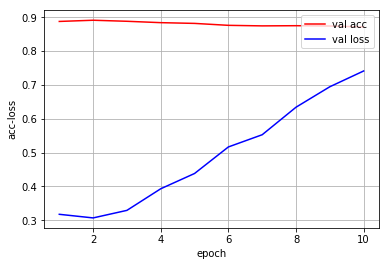

In [2]:
'''slim21 LSTM1'''
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from slim21 import LSTMs

class log(Callback):
    def on_train_begin(self, logs={}):
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(1, len(self.val_loss[loss_type])+1)
        plt.figure()
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'r', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'b', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.grid()
        plt.show()

data = pd.read_csv('input/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])
print(data.CATEGORY.value_counts())
num_of_categories = 20000

# take 20000 data of each category to have balanced data
# and shuffle the dataset
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e, b, t, m], ignore_index=True)
concated = concated.reindex(np.random.permutation(concated.index))

# one-hot encode the labels
concated['LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
labels = to_categorical(concated['LABEL'], num_classes=4)
concated.drop(['CATEGORY'], axis=1)

# tokenize the title data
max_num_words = 8000
max_sequence_length = 150
tokenizer = Tokenizer(num_words = max_num_words)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))
data_processed = pad_sequences(sequences, maxlen=max_sequence_length)

# prepare the training and test data
x_train, x_test, y_train, y_test = train_test_split(data_processed, labels, test_size=0.25, random_state=7)
# define hyperparameters
epochs = 10
embedding_dim = 128
batch_size = 128
learning_rate = 0.001
HISTORY = log()

# build the model
model = Sequential()
model.add(Embedding(max_num_words, embedding_dim, input_length=data_processed.shape[1]))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(LSTMs(implementation=1, units=64, activation='tanh', input_shape=x_train.shape[1:], model='LSTM1'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(lr=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.25,
                 callbacks=[HISTORY])

scores = model.evaluate(x_test, y_test)

print('test loss:', scores[0])
print('test accuracy:', scores[1])

# draw the callback function
HISTORY.loss_plot('epoch')
